# Typhoid_SIM

## 2018 Model, Pakistan: Demonstrating Vaccine Efficacy

## Introduction

### Install special versions of emodpy*

The docker image we are running out of normally has all the required packages. We may yet create a new docker image so this step isn't necessary. But for now, we need to install some special versions of emodpy-related packages in order to handle the 2018 model correctly. 

In [ ]:
!pip3 install -r requirements.txt
!pip3 freeze|grep emod

Looking in indexes: https://packages.idmod.org/api/pypi/pypi-production/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 611.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Show package versions (OPTIONAL)

This step is completely optional. We do this at the end of the previous step. But we may want to just quickly check again.

In [ ]:
!pip3 freeze|egrep "emod|idm"

emod-api==1.31.0.dev0
emod-typhoid==0.0.4.dev2
emodpy==1.22.0.dev3
emodpy-typhoid==0.0.5
idmtools==1.7.8
idmtools-models==1.7.8
idmtools-platform-comps==1.7.8


### Imports

Sometimes we like to just make sure everything we are going to need is installed where it should be before we starting running code.

In [ ]:
import pandas as pd
import numpy as np
import pathlib # for a join
from functools import partial
import itertools

# idmtools ...
from idmtools.assets import Asset, AssetCollection  #
from idmtools.builders import SimulationBuilder
from idmtools.core.platform_factory import Platform
from idmtools.entities.experiment import Experiment
from idmtools_platform_comps.utils.python_requirements_ac.requirements_to_asset_collection import RequirementsToAssetCollection
from idmtools_models.templated_script_task import get_script_wrapper_unix_task
from idmtools.entities.templated_simulation import TemplatedSimulations

# emodpy
from emodpy.emod_task import EMODTask
import emodpy.emod_task
import emod_api.interventions.common as comm

import manifest

from emodpy_typhoid.utility.sweeping import ItvFn, set_param, sweep_functions

/!\ WARNING: File 'idmtools.ini' Not Found! For details on how to configure idmtools, see https://docs.idmod.org/projects/idmtools/en/v1.7.8/configuration.html for details on how to configure idmtools.


### Unpack model from install

In [ ]:
import emod_typhoid.bootstrap as dtk
dtk.setup( manifest.model_dl_dir )

## Methods

The design of our experiment is to run a Typhoid_SIM simulation from 2005 to 2025, and an initial population of 16k, structured and growing in a Pakistan-like way. We seed the infection early and let it become endemic, transmitting through contact and environmental routes.

After 10 years, in 2015, we introduce a vaccination campaign to the entire population, and roll-out a vaccination to 9-month olds. 

We do a 2-D sweep across vaccine efficacy and Run_Number. The former is to explore and document parameter sensitivity and the latter is to normalize for stochasticity.

Note that we hold the vaccine efficacy constant for now as we want to isolate the effects of vaccine efficacy and minimize the number of moving parts.

### Functions for Configuration, Demographics, and Campaign

In [ ]:
BASE_YEAR = 2005
SIMULATION_DURATION_IN_YEARS = 20
CAMP_START_YEAR = 2015


def year_to_days(year):
    return ((year - BASE_YEAR) * 365)

def set_param_fn(config):
    config.parameters.Simulation_Type = "TYPHOID_SIM"
    config.parameters.Simulation_Duration = SIMULATION_DURATION_IN_YEARS * 365.0
    config.parameters.Base_Individual_Sample_Rate = 0.2

    config.parameters.Base_Year = BASE_YEAR
    config.parameters.Inset_Chart_Reporting_Start_Year = BASE_YEAR
    config.parameters.Inset_Chart_Reporting_Stop_Year = 2030
    config.parameters.Enable_Demographics_Reporting = 0
    #config.parameters.Enable_Property_Output = 1  # crash
    config.parameters.Report_Event_Recorder_Events = ["VaccineDistributed", "PropertyChange"]
    config.parameters["Listed_Events"] = ["VaccineDistributed"]  # old school

    config.parameters.Report_Typhoid_ByAgeAndGender_Start_Year = 2010
    config.parameters.Report_Typhoid_ByAgeAndGender_Stop_Year = 2030
    config.parameters.Age_Initialization_Distribution_Type = "DISTRIBUTION_COMPLEX"
    config.parameters.Typhoid_3year_Susceptible_Fraction = 0
    config.parameters.Typhoid_6month_Susceptible_Fraction = 0
    config.parameters.Typhoid_6year_Susceptible_Fraction = 0
    config.parameters.Typhoid_Acute_Infectiousness = 13435
    config.parameters.Typhoid_Carrier_Probability = 0.108
    config.parameters.Typhoid_Carrier_Removal_Year = 2500
    config.parameters.Typhoid_Chronic_Relative_Infectiousness = 0.241
    config.parameters.Typhoid_Contact_Exposure_Rate = 0.06918859049226553
    config.parameters.Typhoid_Environmental_Exposure_Rate = 0.06169346985005757
    config.parameters.Typhoid_Environmental_Cutoff_Days = 157.20690133538764
    config.parameters.Typhoid_Environmental_Peak_Start = 355.0579483941714
    config.parameters.Typhoid_Environmental_Ramp_Down_Duration = 112.30224910440123
    config.parameters.Typhoid_Environmental_Ramp_Up_Duration = 39.540475369174146
    config.parameters.Typhoid_Exposure_Lambda = 7.0
    config.parameters.Typhoid_Prepatent_Relative_Infectiousness = 0.5
    config.parameters.Typhoid_Protection_Per_Infection = 0.98
    config.parameters.Typhoid_Subclinical_Relative_Infectiousness = 1
    config.parameters.Typhoid_Symptomatic_Fraction = 0.07
    # config.parameters.x_Birth = 1.2

    # when using 2018 binary
    import emodpy_typhoid.config as config_utils
    config_utils.cleanup_for_2018_mode(config)
    return config


def build_camp():
    import emod_api.campaign as camp

    print(f"Telling emod-api to use {manifest.schema_file} as schema.")
    camp.set_schema(manifest.schema_file)
    import emodpy_typhoid.interventions.outbreak as ob
    ob_event = ob.add_outbreak_individual(start_day=1,
                                          demographic_coverage=0.05,
                                          node_ids=[1],
                                          repetitions= 5,
                                          timesteps_between_repetitions=30,
                                          #ind_property_restrictions=["Region:A"]
                                          )
    camp.add(ob_event)
    return camp


def build_demog():
    """
    Build a demographics input file for the DTK using emod_api. 
    """
    import emodpy_typhoid.demographics.TyphoidDemographics as Demographics  # OK to call into emod-api

    demog = Demographics.from_template_node(lat=0, lon=0, pop=10000, name=1, forced_id=1)
    # We're getting all our demographics from a static file overlay.

    """
    # This doesn't work right now but still want to leave in example of what we want to be able to do soon.
    demog.AddAgeDependentTransmission( 
            Age_Bin_Edges_In_Years = [0, 5, 20, 60, -1],
            TransmissionMatrix = [
                [1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 1.0]
            ]
    )
    """

    """
    demog.AddIndividualPropertyAndHINT(Property="Region",
                                       Values=["A", "B", "C", "D"],
                                       InitialDistribution=[0.25, 0.25, 0.25, 0.25],
                                       TransmissionMatrix=[
                                           [0.0, 1.0, 2.0, 5.0],
                                           [0.0, 0.0, 0.0, 0.0],
                                           [0.0, 0.0, 0.0, 0.0],
                                           [0.0, 0.0, 0.0, 0.0]
                                       ],
                                       EnviroTransmissionMatrix=[
                                           [0.0, 1.0, 2.0, 5.0],
                                           [0.0, 0.0, 0.0, 0.0],
                                           [0.0, 0.0, 0.0, 0.0],
                                           [0.0, 0.0, 0.0, 0.0]
                                       ]
                                       )
    """
    return demog


def add_vax_intervention(campaign, values):
    import emodpy_typhoid.interventions.typhoid_vaccine as tv
    print(f"Telling emod-api to use {manifest.schema_file} as schema.")
    campaign.set_schema(manifest.schema_file)
    ria = tv.new_routine_immunization(campaign,
                                      efficacy=values['efficacy'],
                                      constant_period=36500,
                                      decay_constant=values['decay_constant'],
                                      start_day=year_to_days(CAMP_START_YEAR) + values['start_day_offset'],
                                      coverage=values['coverage']
                                      )

    notification_iv = comm.BroadcastEvent(campaign, "VaccineDistributed")
    campaign.add(ria)
    #
    tv_iv = tv.new_vax(campaign,
                       efficacy=values['efficacy'],
                       decay_constant=values['decay_constant'],
                       constant_period=36500
                       )
    one_time_campaign = comm.ScheduledCampaignEvent(campaign,
                                                    Start_Day=year_to_days(CAMP_START_YEAR) + values['start_day_offset'],
                                                    Intervention_List=[tv_iv, notification_iv],
                                                    Demographic_Coverage=values['coverage']
                                                    #Target_Age_Min=0.75,
                                                    #Target_Age_Max=15
                                                    )
    campaign.add(one_time_campaign)
    return {"start_day": values['start_day_offset'], 'efficacy': values['efficacy'], 'coverage': values['coverage'],
            'decay': values['decay_constant']}


def get_sweep_builders(sweep_list):
    """
    Build simulation builders.
    Args:
        kwargs: User inputs may overwrite the entries in the block.

    Returns:
        lis of Simulation builders
    """
    builder = SimulationBuilder()
    funcs_list = [[
        ItvFn(add_vax_intervention, ce),
        partial(set_param, param='Run_Number', value=x),
    ]
        for ce in sweep_list  # for sweep on sweep_list
        for x in range(5)  # for sweep Run_Number
    ]

    builder.add_sweep_definition(sweep_functions, funcs_list)

    return [builder]


def run():
    # Create a platform
    # Show how to dynamically set priority and node_group
    platform = Platform("SLURM", node_group="idm_48cores", priority="Highest")
    #platform = Platform("SLURMStage", node_group="idm_48cores", priority="Highest")

    task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path,
                                  campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file,
                                  param_custom_cb=set_param_fn, ep4_custom_cb=None)
    # normally we don't force-set parameters at this point
    task.config.parameters.Demographics_Filenames = ["demographics.json","TestDemographics_pak_updated.json"]
    task.config.parameters.Death_Rate_Dependence = "NONDISEASE_MORTALITY_BY_YEAR_AND_AGE_FOR_EACH_GENDER"
    task.config.parameters.Birth_Rate_Dependence = "INDIVIDUAL_PREGNANCIES_BY_AGE_AND_YEAR"
    task.common_assets.add_directory(assets_directory=manifest.assets_input_dir)
    task.set_sif(manifest.sif)


    # Create simulation sweep with builders -- ShChen method
    start_day_offset = [1]
    #vax_effs = np.linspace(0, 1.0, 3)  # 0.0, 0.5, 1.0
    vax_effs = np.linspace(0.1, 1.0, 10)  # 0.0, 0.5, 1.0
    #decay = [2000, 3000]
    decay = [3000]
    #cov = np.linspace(start=0.0, stop=1.0, num=2)
    cov = [1]
    sweep_list = []
    combinations = list(itertools.product(start_day_offset, vax_effs, cov, decay))
    for c in combinations:
        sweep_list.append({'start_day_offset': c[0], 'efficacy': c[1], 'coverage': c[2], 'decay_constant': c[3]})
    builders = get_sweep_builders(sweep_list)


    # create TemplatedSimulations from task and builders
    ts = TemplatedSimulations(base_task=task, builders=builders)
    # create experiment from TemplatedSimulations
    experiment = Experiment.from_template(ts, name="test_hint")
    # The last step is to call run() on the ExperimentManager to run the simulations.
    experiment.run(wait_until_done=True, platform=platform)
    task.handle_experiment_completion(experiment)

    # download and plot some stuff.
    EMODTask.get_file_from_comps(experiment.uid, ["InsetChart.json", "ReportTyphoidByAgeAndGender.csv"])
    task.cache_experiment_metadata_in_sql(experiment.uid)
    return str(experiment.uid)


### Run the Model

The following long block of code does everything to run the model. It will prompt you for your COMPS credentials. We could break this up into small chunks if that is preferable.

In [ ]:
experiment_id = run()

Assets/Eradication(_ZN6Kernel17SimulationTyphoidC1Ev+0x9) [0x65db69]
Assets/Eradication(_ZN6Kernel17SimulationTyphoid16CreateSimulationEPK13Configuration+0x1e) [0x65dc5e]
Assets/Eradication(_ZN6Kernel17SimulationFactory16CreateSimulationEv+0x59f) [0x51a01f]
Assets/Eradication(_ZN17DefaultController16execute_internalEv+0x78) [0x4f7cc8]
Assets/Eradication(_Z21ControllerInitWrapperiPPcPN6IdmMpi16MessageInterfaceE+0x1b91) [0x687ce1]
Assets/Eradication(_Z14MPIInitWrapperiPPc+0x1e) [0x689a2e]
Assets/Eradication(main+0x30f) [0x4e14ef]
/lib64/libc.so.6(__libc_start_main+0xf5) [0x2ae4b9981555]
Assets/Eradication() [0x4e2cd7]

application called MPI_Abort(MPI_COMM_WORLD, -1) - process 0
00:00:00 [0] [E] [Eradication] 

FileNotFoundException: 
Exception in utils/Environment.cpp at 196 in FindFileOnPath.
Could not find file ./Assets/TestDemographics_pak_updated.json

Assets/Eradication() [0x6d8b23]
Assets/Eradication(_ZN6Kernel17DetailedExceptionC1EPKciS2_+0x2c5) [0x6d96f5]
Assets/Eradication(_ZN6

NameError: name 'exit' is not defined

### Add a "Cumulative Incidence" channel for Contact and Environment routes

In [ ]:
print( f"EXPERIMENT ID = {experiment_id}")
!./post_proc.sh

EXPERIMENT ID = 0701fe07-7c72-ee11-aa0b-b88303911bc1


## Results

### Plot the mean of each Cumulative Contact Incidence by Efficacy 

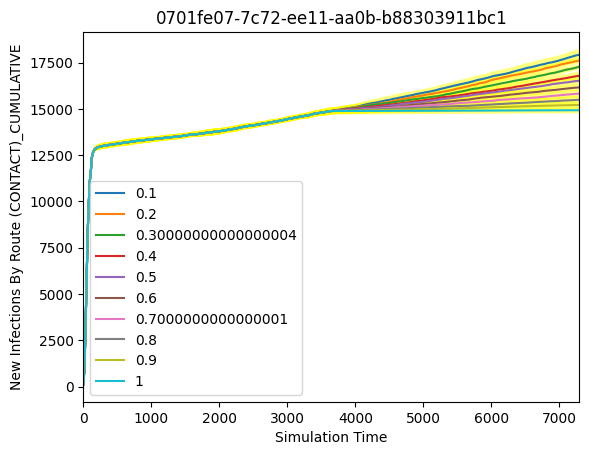

In [ ]:
import matplotlib
import emod_api.channelreports.plot_icj_means as plotter

channel = "New Infections By Route (CONTACT)_CUMULATIVE"

chan_data = plotter.collect(experiment_id, channel, tag="efficacy=SWEEP")
plotter.display(chan_data, False, channel, experiment_id)

## Discussion

We see in the above plot that new infections shoot up during the early seeding outbreak, then they grow slowly but steadily during the endemic phase. Then at the 3650 (10 year) mark we introduce a 1-time campaign (all population) and roll out a vaccination program to all 9-month olds. The efficacy is constant. We sweep over efficacy to demonstrate parameter sensitivity. We see that 100% efficacy causes the new infections to stop completely, as we'd hope. On the other hand, 10% efficacy is close to baseline. And the other values spread out across the range between elimination and baseline.

In [ ]:
Experiment

idmtools.entities.experiment.Experiment

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3f350c2f-0f2a-4e4a-af8a-0f305b8cd444' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>